In [1]:
import pandas as pd
import numpy as np

# Cargar el CSV que subiste
df_alemania = pd.read_csv("/content/drive/MyDrive/ProyectoAnalisis/csv_data/Serie_A_2016-2024_model_data.csv")

# Visualizar las primeras columnas para revisar los nombres
print(df_alemania.columns)

# Renombrar columnas para que coincidan con el modelo
df_alemania = df_alemania.rename(columns={
    'h_team': 'home_team_name',
    'a_team': 'away_team_name',
    'goals_h': 'home_team_goal',
    'goals_a': 'away_team_goal',
    'date': 'match_date'
})

# Generar resultado en texto como lo usamos en el modelo
df_alemania['resultado'] = df_alemania.apply(lambda row: 'home_win' if row['home_team_goal'] > row['away_team_goal']
                           else ('away_win' if row['home_team_goal'] < row['away_team_goal']
                           else 'draw'), axis=1)

# Visualizar las primeras filas para revisar
display(df_alemania.head())

# Revisar tipos de columnas
print(df_alemania.dtypes)

output_file = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_italia.csv"
df_alemania.to_csv(output_file, index=False)


Index(['season_year_start', 'league_name', 'match_date', 'home_team_name',
       'away_team_name', 'home_team_goal', 'away_team_goal', 'home_aggression',
       'away_aggression', 'resultado'],
      dtype='object')


,season_year_start,league_name,match_date,home_team_name,away_team_name,home_team_goal,away_team_goal,home_aggression,away_aggression,resultado,B365H,B365D,B365A
0,2016,Serie A,2016-08-20,Roma,Udinese,4,0,0,2,home_win,2.56,4.03,6.53
1,2016,Serie A,2016-08-20,Juventus,Fiorentina,2,1,1,3,home_win,4.81,3.75,2.42
2,2016,Serie A,2016-08-21,AC Milan,Torino,3,2,3,3,home_win,3.95,4.02,2.17
3,2016,Serie A,2016-08-21,Palermo,Sassuolo,0,1,4,2,away_win,3.43,2.58,1.97
4,2016,Serie A,2016-08-21,Pescara,Napoli,2,2,3,2,draw,1.71,4.17,6.50


season_year_start      int64
league_name           object
match_date            object
home_team_name        object
away_team_name        object
home_team_goal         int64
away_team_goal         int64
home_aggression        int64
away_aggression        int64
resultado             object
B365H                float64
B365D                float64
B365A                float64
dtype: object


In [31]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Football Match Analysis") \
    .getOrCreate()

# Ruta base a tus archivos (ajústala si es necesario)
base_path = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/"

# Cargar archivos CSV
df_country = spark.read.csv(base_path + "Country.csv", header=True, inferSchema=True)
df_league = spark.read.csv(base_path + "League.csv", header=True, inferSchema=True)
df_match = spark.read.csv(base_path + "Match.csv", header=True, inferSchema=True)
df_team = spark.read.csv(base_path + "Team.csv", header=True, inferSchema=True)
df_team_attr = spark.read.csv(base_path + "Team_Attributes.csv", header=True, inferSchema=True)

# Mostrar esquemas para entender la estructura
print("🔹 Country")
df_country.printSchema()
print("🔹 League")
df_league.printSchema()
print("🔹 Match")
df_match.printSchema()
print("🔹 Team")
df_team.printSchema()
print("🔹 Team Attributes")
df_team_attr.printSchema()

# Mostrar algunas filas de ejemplo de Match (base principal)
df_match.select("id", "date", "home_team_api_id", "away_team_api_id",
                "home_team_goal", "away_team_goal").show(5)


🔹 Country
root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)

🔹 League
root
 |-- id: integer (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- name: string (nullable = true)

🔹 Match
root
 |-- id: string (nullable = true)
 |-- country_id: string (nullable = true)
 |-- league_id: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- stage: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- match_api_id: integer (nullable = true)
 |-- home_team_api_id: integer (nullable = true)
 |-- away_team_api_id: integer (nullable = true)
 |-- home_team_goal: integer (nullable = true)
 |-- away_team_goal: integer (nullable = true)
 |-- home_player_X1: integer (nullable = true)
 |-- home_player_X2: integer (nullable = true)
 |-- home_player_X3: integer (nullable = true)
 |-- home_player_X4: integer (nullable = true)
 |-- home_player_X5: integer (nullable = true)
 |-- home_player_X6: integer (nullable = true)
 |-- home_player_X7

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, desc, row_number
from pyspark.sql.window import Window

# Crear sesión de Spark
spark = SparkSession.builder.appName("Football Match Analysis").getOrCreate()

# Ruta base a tus archivos
base_path = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/"  # <- CAMBIA ESTO si hace falta

# Cargar archivos CSV
df_country = spark.read.csv(base_path + "Country.csv", header=True, inferSchema=True)
df_league = spark.read.csv(base_path + "League.csv", header=True, inferSchema=True)
df_match = spark.read.csv(base_path + "Match.csv", header=True, inferSchema=True)
df_team = spark.read.csv(base_path + "Team.csv", header=True, inferSchema=True)
df_team_attr = spark.read.csv(base_path + "Team_Attributes.csv", header=True, inferSchema=True)

# Convertir fecha de los partidos
df_match = df_match.withColumn("date", to_date("date"))

# ------------------- FILTRAR LIGAS DESEADAS -------------------
ligas_deseadas = [
    "England Premier League",
    "France Ligue 1",
    "Germany 1. Bundesliga",
    "Italy Serie A",
    "Spain LIGA BBVA"
]

# Unir para agregar nombres de liga y filtrar
df_match = df_match.join(df_league, df_match.league_id == df_league.id, "left") \
                   .filter(col("name").isin(ligas_deseadas)) \
                   .drop("id", "country_id", "name")  # eliminamos columnas duplicadas

# ------------------- Nombres de equipos -------------------
df_match = df_match \
    .join(df_team.withColumnRenamed("team_api_id", "home_team_api_id_ref") \
                 .withColumnRenamed("team_long_name", "home_team_name"),
          df_match["home_team_api_id"] == col("home_team_api_id_ref"), "left") \
    .drop("home_team_api_id_ref") \
    .join(df_team.withColumnRenamed("team_api_id", "away_team_api_id_ref") \
                 .withColumnRenamed("team_long_name", "away_team_name"),
          df_match["away_team_api_id"] == col("away_team_api_id_ref"), "left") \
    .drop("away_team_api_id_ref")

# ------------------- Atributos de equipos (último disponible) -------------------
window_spec = Window.partitionBy("team_api_id").orderBy(desc("date"))

# Local
df_team_attr_local = df_team_attr \
    .withColumn("row_num", row_number().over(window_spec)) \
    .filter(col("row_num") == 1) \
    .drop("row_num") \
    .withColumnRenamed("team_api_id", "home_team_api_id") \
    .withColumnRenamed("buildUpPlaySpeed", "home_speed") \
    .withColumnRenamed("defenceAggression", "home_aggression") \
    .withColumnRenamed("date", "home_attr_date")

# Visitante
df_team_attr_away = df_team_attr \
    .withColumn("row_num", row_number().over(window_spec)) \
    .filter(col("row_num") == 1) \
    .drop("row_num") \
    .withColumnRenamed("team_api_id", "away_team_api_id") \
    .withColumnRenamed("buildUpPlaySpeed", "away_speed") \
    .withColumnRenamed("defenceAggression", "away_aggression") \
    .withColumnRenamed("date", "away_attr_date")

# ------------------- Unir atributos -------------------
df_final = df_match \
    .join(df_team_attr_local, on="home_team_api_id", how="left") \
    .join(df_team_attr_away, on="away_team_api_id", how="left")

# ------------------- Resultado del partido -------------------
df_final = df_final.withColumn(
    "resultado",
    when(col("home_team_goal") > col("away_team_goal"), "home_win")
    .when(col("home_team_goal") < col("away_team_goal"), "away_win")
    .otherwise("draw")
)

# ------------------- Dataset final para modelado -------------------
df_model = df_final.select(
    df_match["date"].alias("match_date"),
    "home_team_name", "away_team_name",
    "home_team_goal", "away_team_goal",
    "home_speed", "home_aggression",
    "away_speed", "away_aggression",
    "resultado"
)

# Mostrar ejemplo
df_model.show(10)


+----------+-----------------+--------------------+--------------+--------------+----------+---------------+----------+---------------+---------+
|match_date|   home_team_name|      away_team_name|home_team_goal|away_team_goal|home_speed|home_aggression|away_speed|away_aggression|resultado|
+----------+-----------------+--------------------+--------------+--------------+----------+---------------+----------+---------------+---------+
|2008-08-17|Manchester United|    Newcastle United|             1|             1|        38|             53|        58|             39|     draw|
|2008-08-16|          Arsenal|West Bromwich Albion|             1|             0|        59|             44|        62|             40| home_win|
|2008-08-16|       Sunderland|           Liverpool|             0|             1|        43|             45|        66|             52| away_win|
|2008-08-16|  West Ham United|      Wigan Athletic|             2|             1|        77|             37|        51|     

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, desc, row_number
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Iniciar Spark
spark = SparkSession.builder.appName("FootballModel").getOrCreate()

# Ruta base
base_path = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/"

# Cargar datasets
df_league = spark.read.csv(base_path + "League.csv", header=True, inferSchema=True)
df_match = spark.read.csv(base_path + "Match.csv", header=True, inferSchema=True)
df_team = spark.read.csv(base_path + "Team.csv", header=True, inferSchema=True)
df_team_attr = spark.read.csv(base_path + "Team_Attributes.csv", header=True, inferSchema=True)

# Convertir fechas
df_match = df_match.withColumn("date", to_date("date"))
df_team_attr = df_team_attr.withColumn("date", to_date("date"))

# ---------------- FILTRAR LIGAS DESEADAS ----------------
ligas_deseadas = [
    "England Premier League",
    "France Ligue 1",
    "Germany 1. Bundesliga",
    "Italy Serie A",
    "Spain LIGA BBVA"
]

# Unir para agregar nombre de liga y filtrar
df_match = df_match.join(df_league, df_match.league_id == df_league.id, "left") \
                   .filter(col("name").isin(ligas_deseadas)) \
                   .drop("id", "country_id", "name")

# ---------------- ATRIBUTOS DE EQUIPOS (último por equipo) ----------------
window_spec = Window.partitionBy("team_api_id").orderBy(desc("date"))

df_team_attr_latest = df_team_attr \
    .withColumn("rn", row_number().over(window_spec)) \
    .filter(col("rn") == 1).drop("rn")

# Atributos local y visitante
df_team_attr_local = df_team_attr_latest.select(
    col("team_api_id").alias("home_team_api_id"),
    col("buildUpPlaySpeed").alias("home_speed"),
    col("defenceAggression").alias("home_aggression")
)

df_team_attr_away = df_team_attr_latest.select(
    col("team_api_id").alias("away_team_api_id"),
    col("buildUpPlaySpeed").alias("away_speed"),
    col("defenceAggression").alias("away_aggression")
)

# Renombrar equipos
df_team_home = df_team.select(
    col("team_api_id").alias("home_team_api_id_ref"),
    col("team_long_name").alias("home_team_name")
)

df_team_away = df_team.select(
    col("team_api_id").alias("away_team_api_id_ref"),
    col("team_long_name").alias("away_team_name")
)

# ---------------- UNIÓN FINAL ----------------
df_final = df_match \
    .join(df_team_home, df_match["home_team_api_id"] == col("home_team_api_id_ref"), "left") \
    .drop("home_team_api_id_ref") \
    .join(df_team_away, df_match["away_team_api_id"] == col("away_team_api_id_ref"), "left") \
    .drop("away_team_api_id_ref") \
    .join(df_team_attr_local, on="home_team_api_id", how="left") \
    .join(df_team_attr_away, on="away_team_api_id", how="left") \
    .withColumn("resultado", when(col("home_team_goal") > col("away_team_goal"), "home_win")
                              .when(col("home_team_goal") < col("away_team_goal"), "away_win")
                              .otherwise("draw"))

# Dataset final
df_model = df_final.select(
    col("date").alias("match_date"),
    "home_team_name", "away_team_name",
    "home_team_goal", "away_team_goal",
    "home_speed", "home_aggression",
    "away_speed", "away_aggression",
    "B365H", "B365D", "B365A",
    "resultado"
)

# ---------------- MODELADO ----------------
# Quitar filas con valores nulos
df_model_clean = df_model.dropna(subset=[
    "home_speed", "home_aggression", "away_speed", "away_aggression",
    "B365H", "B365D", "B365A", "resultado"
])

# StringIndexer + VectorAssembler + Random Forest
label_indexer = StringIndexer(inputCol="resultado", outputCol="label")
assembler = VectorAssembler(
    inputCols=[
        "home_speed", "home_aggression",
        "away_speed", "away_aggression",
        "B365H", "B365D", "B365A"
    ],
    outputCol="features"
)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[label_indexer, assembler, rf])

# Train-test split
train, test = df_model_clean.randomSplit([0.8, 0.2], seed=42)

# Entrenar modelo
model = pipeline.fit(train)

# Predecir
predictions = model.transform(test)

# Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"✅ Precisión del modelo: {accuracy:.2%}")


✅ Precisión del modelo: 53.21%


In [34]:
df_model_clean.printSchema()

root
 |-- match_date: date (nullable = true)
 |-- home_team_name: string (nullable = true)
 |-- away_team_name: string (nullable = true)
 |-- home_team_goal: integer (nullable = true)
 |-- away_team_goal: integer (nullable = true)
 |-- home_speed: integer (nullable = true)
 |-- home_aggression: integer (nullable = true)
 |-- away_speed: integer (nullable = true)
 |-- away_aggression: integer (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- resultado: string (nullable = false)



In [112]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, desc, row_number
from pyspark.sql.window import Window

# Iniciar Spark
spark = SparkSession.builder.appName("PreprocesamientoPartidos").getOrCreate()

# Ruta base
base_path = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/"

# Cargar datasets necesarios
df_league = spark.read.csv(base_path + "League.csv", header=True, inferSchema=True)
df_match = spark.read.csv(base_path + "Match.csv", header=True, inferSchema=True)
df_team = spark.read.csv(base_path + "Team.csv", header=True, inferSchema=True)
df_team_attr = spark.read.csv(base_path + "Team_Attributes.csv", header=True, inferSchema=True)

# Convertir fechas
df_match = df_match.withColumn("date", to_date("date"))
df_team_attr = df_team_attr.withColumn("date", to_date("date"))

# ---------------- FILTRAR LIGAS IMPORTANTES ----------------
ligas_deseadas = [
    "England Premier League",
    "France Ligue 1",
    "Germany 1. Bundesliga",
    "Italy Serie A",
    "Spain LIGA BBVA"
]

# Unir para obtener nombre de liga y filtrar
df_match = df_match.join(df_league, df_match.league_id == df_league.id, "left") \
                   .filter(col("name").isin(ligas_deseadas)) \
                   .drop("id", "country_id", "name")

# ---------------- ÚLTIMOS ATRIBUTOS POR EQUIPO ----------------
window_spec = Window.partitionBy("team_api_id").orderBy(desc("date"))
df_team_attr_latest = df_team_attr.withColumn("rn", row_number().over(window_spec)) \
                                  .filter(col("rn") == 1).drop("rn")

# Separar atributos locales y visitantes
df_team_attr_local = df_team_attr_latest.select(
    col("team_api_id").alias("home_team_api_id"),
    col("buildUpPlaySpeed").alias("home_speed"),
    col("defenceAggression").alias("home_aggression")
)

df_team_attr_away = df_team_attr_latest.select(
    col("team_api_id").alias("away_team_api_id"),
    col("buildUpPlaySpeed").alias("away_speed"),
    col("defenceAggression").alias("away_aggression")
)

# Renombrar nombres de equipos
df_team_home = df_team.select(
    col("team_api_id").alias("home_team_api_id_ref"),
    col("team_long_name").alias("home_team_name")
)

df_team_away = df_team.select(
    col("team_api_id").alias("away_team_api_id_ref"),
    col("team_long_name").alias("away_team_name")
)

# ---------------- UNIÓN FINAL ----------------
df_final = df_match \
    .join(df_team_home, df_match["home_team_api_id"] == col("home_team_api_id_ref"), "left") \
    .drop("home_team_api_id_ref") \
    .join(df_team_away, df_match["away_team_api_id"] == col("away_team_api_id_ref"), "left") \
    .drop("away_team_api_id_ref") \
    .join(df_team_attr_local, on="home_team_api_id", how="left") \
    .join(df_team_attr_away, on="away_team_api_id", how="left") \
    .withColumn("resultado", when(col("home_team_goal") > col("away_team_goal"), "home_win")
                              .when(col("home_team_goal") < col("away_team_goal"), "away_win")
                              .otherwise("draw"))

# Dataset limpio para modelado
df_model = df_final.select(
    col("date").alias("match_date"),
    "home_team_name", "away_team_name",
    "home_team_goal", "away_team_goal",
    "home_speed", "home_aggression",
    "away_speed", "away_aggression",
    "B365H", "B365D", "B365A",
    "resultado"
)

# Quitar nulos
df_model_clean = df_model.dropna(subset=[
    "home_speed", "home_aggression", "away_speed", "away_aggression",
    "B365H", "B365D", "B365A", "resultado"
])

# Cargar CSVs finales corregidos
path_finales = [
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_alemania_final.csv",
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_italia_final.csv",
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_españa_final.csv",
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_inglaterra_final.csv",
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_francia_final.csv"
]

# Leer cada archivo como un DataFrame de Spark
df_finales = [spark.read.csv(path, header=True, inferSchema=True) for path in path_finales]

# Asegurar tipos compatibles (convertir columnas si hace falta)
for i in range(len(df_finales)):
    df_finales[i] = df_finales[i].withColumn("match_date", to_date("match_date"))

# Unir todos los nuevos datasets en uno solo
df_extra_union = df_finales[0]
for df in df_finales[1:]:
    df_extra_union = df_extra_union.unionByName(df)

# Unir con df_model_clean
df_total = df_model_clean.unionByName(df_extra_union)

# Quitar nulos
df_total = df_total.dropna(subset=[
    "home_speed", "home_aggression", "away_speed", "away_aggression",
    "B365H", "B365D", "B365A", "resultado"
])

# Mostrar resumen final
df_total.printSchema()
df_total.show(10)

# Train-test split
train, test = df_total.randomSplit([0.8, 0.2], seed=42)

# Entrenar modelo
model = pipeline.fit(train)

# Predecir
predictions = model.transform(test)

# Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Weighted F1-score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)

print(f"✅ Precisión del modelo (Acc): {accuracy:.2%}")
print(f"✅ Precisión del modelo (F1): {f1_score:.2%}")


root
 |-- match_date: date (nullable = true)
 |-- home_team_name: string (nullable = true)
 |-- away_team_name: string (nullable = true)
 |-- home_team_goal: integer (nullable = true)
 |-- away_team_goal: integer (nullable = true)
 |-- home_speed: integer (nullable = true)
 |-- home_aggression: double (nullable = true)
 |-- away_speed: integer (nullable = true)
 |-- away_aggression: double (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- resultado: string (nullable = true)

+----------+-----------------+--------------------+--------------+--------------+----------+---------------+----------+---------------+-----+-----+-----+---------+
|match_date|   home_team_name|      away_team_name|home_team_goal|away_team_goal|home_speed|home_aggression|away_speed|away_aggression|B365H|B365D|B365A|resultado|
+----------+-----------------+--------------------+--------------+--------------+----------+---------------+

In [42]:
df_total.coalesce(1).write.csv(
    "/content/drive/MyDrive/ProyectoAnalisis/csv_data/DATASETFINAL",
    header=True,
    mode="overwrite"
)

In [21]:
import pandas as pd
import numpy as np

# Cargar el archivo CSV
df_alemania = pd.read_csv("/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_francia.csv")

# Eliminar columnas innecesarias
df_alemania.drop(columns=['season_year_start', 'league_name'], inplace=True)

# Eliminar columnas auxiliares
df_alemania.drop(columns=['home_category', 'away_category'], inplace=True)

# Verificar
df_alemania.head()


,match_date,home_team_name,away_team_name,home_team_goal,away_team_goal,home_aggression,away_aggression,resultado,B365H,B365D,B365A,home_speed,away_speed
0,2016-08-12,SC Bastia,Paris Saint Germain,0,1,3.0,3.0,away_win,2.56,3.02,5.08,25,100
1,2016-08-12,Monaco,Guingamp,2,2,3.0,4.0,draw,4.81,2.82,6.03,100,75
2,2016-08-13,Bordeaux,Saint-Etienne,3,2,1.0,2.0,home_win,3.95,2.82,3.80,60,70
3,2016-08-13,Montpellier,Angers,1,0,1.0,2.0,home_win,3.43,2.64,1.90,100,70
4,2016-08-13,Caen,Lorient,3,2,1.0,5.0,home_win,1.71,2.87,3.01,55,60


In [22]:
ordered_cols = [
    "match_date", "home_team_name", "away_team_name",
    "home_team_goal", "away_team_goal",
    "home_speed", "home_aggression",
    "away_speed", "away_aggression",
    "B365H", "B365D", "B365A",
    "resultado"
]

df_alemania = df_alemania[ordered_cols]

df_alemania.head()

output_file = "/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_francia.csv"
df_alemania.to_csv(output_file, index=False)


In [24]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00


In [29]:
import pandas as pd
from fuzzywuzzy import process

# Cargar Team.csv con nombres estándar
team_df = pd.read_csv('/content/drive/MyDrive/ProyectoAnalisis/csv_data/Team.csv')
team_names = team_df['team_long_name'].dropna().unique().tolist()

# Cargar el dataset a corregir
alemania = pd.read_csv('/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_francia.csv')

# Función para reemplazar usando fuzzy matching
def corregir_nombre(nombre_equipo):
    if pd.isna(nombre_equipo):
        return nombre_equipo
    mejor_match, score = process.extractOne(nombre_equipo, team_names)
    return mejor_match if score >= 85 else nombre_equipo  # solo si el match es bueno

# Aplicar la corrección a ambas columnas
alemania['home_team_name'] = alemania['home_team_name'].apply(corregir_nombre)
alemania['away_team_name'] = alemania['away_team_name'].apply(corregir_nombre)

# Verificar los cambios
print(alemania[['home_team_name', 'away_team_name']].drop_duplicates().head(10))

# Guardar resultado corregido
alemania.to_csv('/content/drive/MyDrive/ProyectoAnalisis/csv_data/data_francia_final.csv', index=False)


           home_team_name        away_team_name
0               SC Bastia   Paris Saint-Germain
1               AS Monaco  En Avant de Guingamp
2   Girondins de Bordeaux      AS Saint-Étienne
3  Montpellier Hérault SC               Rangers
4                 SM Caen            FC Lorient
5                 FC Metz            LOSC Lille
6               Dijon FCO             FC Nantes
7       AS Nancy-Lorraine    Olympique Lyonnais
8                OGC Nice                Rennes
9  Olympique de Marseille           Toulouse FC


In [43]:
# ------------------ IMPORTACIONES Y SESION ------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.types import StructType, StructField, DoubleType

spark = SparkSession.builder.getOrCreate()

# ------------------ ENTRENAMIENTO DE MODELOS ------------------
# ------------------ CLASIFICACIÓN: Resultado del partido ------------------
indexer = StringIndexer(inputCol="resultado", outputCol="label")
assembler_class = VectorAssembler(
    inputCols=["home_speed", "home_aggression", "away_speed", "away_aggression", "B365H", "B365D", "B365A"],
    outputCol="features"
)
rf_class = RandomForestClassifier(featuresCol="features", labelCol="label")
pipeline_class = Pipeline(stages=[indexer, assembler_class, rf_class])
model_class = pipeline_class.fit(df_total)

# ------------------ REGRESIÓN: Goles por equipo ------------------
assembler_reg = VectorAssembler(
    inputCols=["home_speed", "home_aggression", "away_speed", "away_aggression", "B365H", "B365D", "B365A"],
    outputCol="features"
)

# Modelo para goles del equipo local
rf_home = RandomForestRegressor(featuresCol="features", labelCol="home_team_goal", predictionCol="prediction")
pipeline_home = Pipeline(stages=[assembler_reg, rf_home])
model_home = pipeline_home.fit(df_total)

# Modelo para goles del equipo visitante
rf_away = RandomForestRegressor(featuresCol="features", labelCol="away_team_goal", predictionCol="prediction")
pipeline_away = Pipeline(stages=[assembler_reg, rf_away])
model_away = pipeline_away.fit(df_total)

# ------------------ FUNCIONES AUXILIARES Y OBTENER CARACTERISTICAS POR EQUIPO ------------------
def get_team_features(team_name, df):
    row = df.filter(df.home_team_name == team_name).select(
        "home_speed", "home_aggression", "B365H", "B365D", "B365A"
    ).orderBy("B365H", ascending=False).limit(1).collect()
    if not row:
        raise ValueError(f"Equipo '{team_name}' no encontrado en los datos.")
    return row[0].asDict()

def calcular_valor_esperado(prob_modelo, cuota_real):
    return (prob_modelo * cuota_real) - 1

# ------------------ FUNCION DE PREDICCION ------------------
def predict_match_with_goals(home_team, away_team, model_class, model_home, model_away, df_total):
    home_feats = get_team_features(home_team, df_total)
    away_feats = get_team_features(away_team, df_total)

    data = [{
        "home_speed": float(home_feats["home_speed"]),
        "home_aggression": float(home_feats["home_aggression"]),
        "away_speed": float(away_feats["home_speed"]),
        "away_aggression": float(away_feats["home_aggression"]),
        "B365H": float(home_feats["B365H"]),
        "B365D": float(home_feats["B365D"]),
        "B365A": float(home_feats["B365A"]),
    }]

    schema = StructType([
        StructField("home_speed", DoubleType(), True),
        StructField("home_aggression", DoubleType(), True),
        StructField("away_speed", DoubleType(), True),
        StructField("away_aggression", DoubleType(), True),
        StructField("B365H", DoubleType(), True),
        StructField("B365D", DoubleType(), True),
        StructField("B365A", DoubleType(), True),
    ])

    match_df = spark.createDataFrame(data, schema)

    # Predicción clasificación: obtenemos prediction, labels y probabilidades
    pred_row = model_class.transform(match_df).select("prediction", "probability").first()
    pred_result = pred_row["prediction"]
    prob_vector = pred_row["probability"]

    label_mapping = model_class.stages[0].labels
    result_label = label_mapping[int(pred_result)]

    # Extraemos probabilidades para cada clase (en orden label_mapping)
    p_home_win = prob_vector[label_mapping.index("home_win")] if "home_win" in label_mapping else prob_vector[0]
    p_draw = prob_vector[label_mapping.index("draw")] if "draw" in label_mapping else prob_vector[1]
    p_away_win = prob_vector[label_mapping.index("away_win")] if "away_win" in label_mapping else prob_vector[2]

    # Ajuste de probabilidades para eliminar margen (overround)
    sum_probs = p_home_win + p_draw + p_away_win
    p_home_adj = p_home_win / sum_probs
    p_draw_adj = p_draw / sum_probs
    p_away_adj = p_away_win / sum_probs

    # Cálculo de odds (cuotas)
    odds_home_win = 1 / p_home_adj
    odds_draw = 1 / p_draw_adj
    odds_away_win = 1 / p_away_adj

    # Predicción regresión como float nativo
    pred_home_goals = float(model_home.transform(match_df).select("prediction").first()["prediction"])
    pred_away_goals = float(model_away.transform(match_df).select("prediction").first()["prediction"])

    # Determinar nombre del equipo ganador
    if result_label == 'away_win':
        resultado = away_team
    elif result_label == 'home_win':
        resultado = home_team
    else:
        resultado = 'Empate'

    return {
      "Resultado": resultado,
      "Probabilidades": [
          f"Probabilidad de que gane {home_team}: {p_home_win:.2%}",
          f"Probabilidad de empate: {p_draw:.2%}",
          f"Probabilidad de que gane {away_team}: {p_away_win:.2%}"
      ],
      "Apuestas (odds)": [
          f"Cuota para que gane {home_team}: {odds_home_win:.2f} (EV: {calcular_valor_esperado(p_home_adj, float(home_feats['B365H'])):.2f})",
          f"Cuota para empate: {odds_draw:.2f} (EV: {calcular_valor_esperado(p_draw_adj, float(home_feats['B365D'])):.2f})",
          f"Cuota para que gane {away_team}: {odds_away_win:.2f} (EV: {calcular_valor_esperado(p_away_adj, float(home_feats['B365A'])):.2f})"
      ],
      "Goles esperados": [
          f"Goles esperados para {home_team}: {pred_home_goals:.2f}",
          f"Goles esperados para {away_team}: {pred_away_goals:.2f}"
      ]
    }

In [83]:
# ------------------ IMPORTACIONES Y SESION ------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.types import StructType, StructField, DoubleType

spark = SparkSession.builder.getOrCreate()

# ------------------ ENTRENAMIENTO DE MODELOS ------------------

# ------------------ CLASIFICACIÓN: Resultado del partido ------------------
indexer = StringIndexer(inputCol="resultado", outputCol="label")
assembler_class = VectorAssembler(
    inputCols=["home_speed", "home_aggression", "away_speed", "away_aggression", "B365H", "B365D", "B365A"],
    outputCol="features"
)
rf_class = RandomForestClassifier(featuresCol="features", labelCol="label")
pipeline_class = Pipeline(stages=[indexer, assembler_class, rf_class])
model_class = pipeline_class.fit(df_total)

# ------------------ REGRESIÓN: Goles por equipo ------------------
assembler_reg = VectorAssembler(
    inputCols=["home_speed", "home_aggression", "away_speed", "away_aggression", "B365H", "B365D", "B365A"],
    outputCol="features"
)

# Modelo para goles del equipo local
rf_home = RandomForestRegressor(featuresCol="features", labelCol="home_team_goal", predictionCol="home_prediction")
pipeline_home = Pipeline(stages=[assembler_reg, rf_home])
model_home = pipeline_home.fit(df_total)

# Modelo para goles del equipo visitante
rf_away = RandomForestRegressor(featuresCol="features", labelCol="away_team_goal", predictionCol="away_prediction")
pipeline_away = Pipeline(stages=[assembler_reg, rf_away])
model_away = pipeline_away.fit(df_total)

# ------------------ FUNCIONES AUXILIARES ------------------

def get_team_features(team_name, df):
    row = df.filter((df.home_team_name == team_name) | (df.away_team_name == team_name)) \
            .select("home_team_name", "away_team_name",
                    "home_speed", "home_aggression",
                    "away_speed", "away_aggression",
                    "B365H", "B365D", "B365A") \
            .limit(1) \
            .collect()

    if not row:
        raise ValueError(f"Equipo '{team_name}' no encontrado en los datos.")

    r = row[0]

    # Determinar si el equipo es local o visitante en ese partido
    if r["home_team_name"] == team_name:
        return {
            "home_speed": r["home_speed"],
            "home_aggression": r["home_aggression"],
            "B365H": r["B365H"],
            "B365D": r["B365D"],
            "B365A": r["B365A"]
        }
    else:
        return {
            "home_speed": r["away_speed"],  # el equipo va como visitante en ese partido
            "home_aggression": r["away_aggression"],
            "B365H": r["B365A"],  # invertimos las cuotas
            "B365D": r["B365D"],
            "B365A": r["B365H"]
        }

def calcular_valor_esperado(prob_modelo, cuota_real):
    return (prob_modelo * cuota_real) - 1

# ------------------ FUNCION DE PREDICCION ------------------

def predict_match_with_goals(home_team, away_team, model_class, model_home, model_away, df_total):
    home_feats = get_team_features(home_team, df_total)
    away_feats = get_team_features(away_team, df_total)

    data = [{
        "home_speed": float(home_feats["home_speed"]),
        "home_aggression": float(home_feats["home_aggression"]),
        "away_speed": float(away_feats["home_speed"]),
        "away_aggression": float(away_feats["home_aggression"]),
        "B365H": float(home_feats["B365H"]),
        "B365D": float(home_feats["B365D"]),
        "B365A": float(away_feats["B365A"]),
    }]

    schema = StructType([
        StructField("home_speed", DoubleType(), True),
        StructField("home_aggression", DoubleType(), True),
        StructField("away_speed", DoubleType(), True),
        StructField("away_aggression", DoubleType(), True),
        StructField("B365H", DoubleType(), True),
        StructField("B365D", DoubleType(), True),
        StructField("B365A", DoubleType(), True),
    ])

    match_df = spark.createDataFrame(data, schema)

    # Predicción clasificación: obtenemos prediction, labels y probabilidades
    pred_row = model_class.transform(match_df).select("prediction", "probability").first()
    pred_result = pred_row["prediction"]
    prob_vector = pred_row["probability"]

    label_mapping = model_class.stages[0].labels if hasattr(model_class.stages[0], "labels") else ["home_win", "draw", "away_win"]
    result_label = label_mapping[int(pred_result)]

    # Extraemos probabilidades para cada clase (en orden label_mapping)
    p_home_win = prob_vector[label_mapping.index("home_win")] if "home_win" in label_mapping else prob_vector[0]
    p_draw = prob_vector[label_mapping.index("draw")] if "draw" in label_mapping else prob_vector[1]
    p_away_win = prob_vector[label_mapping.index("away_win")] if "away_win" in label_mapping else prob_vector[2]

    # Ajuste de probabilidades (remover overround)
    sum_probs = p_home_win + p_draw + p_away_win
    p_home_adj = p_home_win / sum_probs
    p_draw_adj = p_draw / sum_probs
    p_away_adj = p_away_win / sum_probs

    # Cálculo de cuotas
    odds_home_win = 1 / p_home_adj
    odds_draw = 1 / p_draw_adj
    odds_away_win = 1 / p_away_adj

    # Predicción regresión
    pred_home_goals = float(model_home.transform(match_df).select("home_prediction").first()["home_prediction"])
    pred_away_goals = float(model_away.transform(match_df).select("away_prediction").first()["away_prediction"])

    # Determinar resultado
    if result_label == 'away_win':
        resultado = away_team
    elif result_label == 'home_win':
        resultado = home_team
    else:
        resultado = 'Empate'

    return {
        "Resultado": resultado,
        "Probabilidades": [
            f"Probabilidad de que gane {home_team}: {p_home_win:.2%}",
            f"Probabilidad de empate: {p_draw:.2%}",
            f"Probabilidad de que gane {away_team}: {p_away_win:.2%}"
        ],
        "Apuestas (odds)": [
            f"Cuota para que gane {home_team}: {odds_home_win:.2f} (EV: {calcular_valor_esperado(p_home_adj, float(home_feats['B365H'])):.2f})",
            f"Cuota para empate: {odds_draw:.2f} (EV: {calcular_valor_esperado(p_draw_adj, float(home_feats['B365D'])):.2f})",
            f"Cuota para que gane {away_team}: {odds_away_win:.2f} (EV: {calcular_valor_esperado(p_away_adj, float(away_feats['B365A'])):.2f})"
        ],
        "Goles esperados": [
            f"Goles esperados para {home_team}: {pred_home_goals:.2f}",
            f"Goles esperados para {away_team}: {pred_away_goals:.2f}"
        ]
    }


In [84]:
pred = predict_match_with_goals("Real Madrid CF", "FC Barcelona", model_class, model_home, model_away, df_total)
print(pred)

{'Resultado': 'Real Madrid CF', 'Probabilidades': ['Probabilidad de que gane Real Madrid CF: 53.36%', 'Probabilidad de empate: 29.43%', 'Probabilidad de que gane FC Barcelona: 17.21%'], 'Apuestas (odds)': ['Cuota para que gane Real Madrid CF: 1.87 (EV: 0.12)', 'Cuota para empate: 3.40 (EV: -0.03)', 'Cuota para que gane FC Barcelona: 5.81 (EV: 0.20)'], 'Goles esperados': ['Goles esperados para Real Madrid CF: 1.50', 'Goles esperados para FC Barcelona: 0.99']}


In [85]:
pred = predict_match_with_goals("FC Barcelona", "Real Madrid CF", model_class, model_home, model_away, df_total)
print(pred)

{'Resultado': 'FC Barcelona', 'Probabilidades': ['Probabilidad de que gane FC Barcelona: 51.63%', 'Probabilidad de empate: 26.80%', 'Probabilidad de que gane Real Madrid CF: 21.57%'], 'Apuestas (odds)': ['Cuota para que gane FC Barcelona: 1.94 (EV: -0.23)', 'Cuota para empate: 3.73 (EV: 0.07)', 'Cuota para que gane Real Madrid CF: 4.64 (EV: -0.25)'], 'Goles esperados': ['Goles esperados para FC Barcelona: 1.67', 'Goles esperados para Real Madrid CF: 0.98']}


In [86]:
# Filtrar partidos entre Real Madrid CF y FC Barcelona (en cualquier orden)
partidos_rmbc = df_total.filter(
    ((df_total.home_team_name == "Real Madrid CF") & (df_total.away_team_name == "FC Barcelona")) |
    ((df_total.home_team_name == "FC Barcelona") & (df_total.away_team_name == "Real Madrid CF"))
)

# Mostrar algunos partidos encontrados
partidos_rmbc.show(50)


+----------+--------------+--------------+--------------+--------------+----------+---------------+----------+---------------+-----+-----+-----+---------+
|match_date|home_team_name|away_team_name|home_team_goal|away_team_goal|home_speed|home_aggression|away_speed|away_aggression|B365H|B365D|B365A|resultado|
+----------+--------------+--------------+--------------+--------------+----------+---------------+----------+---------------+-----+-----+-----+---------+
|2008-12-13|  FC Barcelona|Real Madrid CF|             2|             0|        36|           65.0|        50|           60.0| 1.57|  3.8|  6.0| home_win|
|2009-05-02|Real Madrid CF|  FC Barcelona|             2|             6|        50|           60.0|        36|           65.0|  2.5|  3.4| 2.75| away_win|
|2009-11-29|  FC Barcelona|Real Madrid CF|             1|             0|        36|           65.0|        50|           60.0| 1.85|  3.6|  4.0| home_win|
|2010-04-10|Real Madrid CF|  FC Barcelona|             0|             

In [87]:
# Filtrar partidos entre FC Bayern Munich y Borussia Dortmund (en cualquier orden)
partidos_bmbd = df_total.filter(
    ((df_total.home_team_name == "FC Bayern Munich") & (df_total.away_team_name == "Borussia Dortmund")) |
    ((df_total.home_team_name == "Borussia Dortmund") & (df_total.away_team_name == "FC Bayern Munich"))
)

# Mostrar algunos partidos encontrados
partidos_bmbd.show(50)


+----------+-----------------+-----------------+--------------+--------------+----------+---------------+----------+---------------+-----+-----+-----+---------+
|match_date|   home_team_name|   away_team_name|home_team_goal|away_team_goal|home_speed|home_aggression|away_speed|away_aggression|B365H|B365D|B365A|resultado|
+----------+-----------------+-----------------+--------------+--------------+----------+---------------+----------+---------------+-----+-----+-----+---------+
|2009-02-08| FC Bayern Munich|Borussia Dortmund|             3|             1|        45|           53.0|        71|           71.0| 1.44|  4.0|  8.0| home_win|
|2008-08-23|Borussia Dortmund| FC Bayern Munich|             1|             1|        71|           71.0|        45|           53.0|  3.4| 3.25| 2.15|     draw|
|2010-02-13| FC Bayern Munich|Borussia Dortmund|             3|             1|        45|           53.0|        71|           71.0| 1.33| 4.75|  9.0| home_win|
|2009-09-12|Borussia Dortmund| FC 

In [89]:
pred = predict_match_with_goals("FC Bayern Munich", "Borussia Dortmund", model_class, model_home, model_away, df_total)
print(pred)

{'Resultado': 'FC Bayern Munich', 'Probabilidades': ['Probabilidad de que gane FC Bayern Munich: 37.20%', 'Probabilidad de empate: 25.61%', 'Probabilidad de que gane Borussia Dortmund: 37.19%'], 'Apuestas (odds)': ['Cuota para que gane FC Bayern Munich: 2.69 (EV: -0.42)', 'Cuota para empate: 3.90 (EV: -0.03)', 'Cuota para que gane Borussia Dortmund: 2.69 (EV: -0.24)'], 'Goles esperados': ['Goles esperados para FC Bayern Munich: 1.42', 'Goles esperados para Borussia Dortmund: 1.45']}


In [91]:
pred = predict_match_with_goals("Manchester City", "FC Barcelona", model_class, model_home, model_away, df_total)
print(pred)

{'Resultado': 'Manchester City', 'Probabilidades': ['Probabilidad de que gane Manchester City: 49.37%', 'Probabilidad de empate: 29.90%', 'Probabilidad de que gane FC Barcelona: 20.73%'], 'Apuestas (odds)': ['Cuota para que gane Manchester City: 2.03 (EV: 1.14)', 'Cuota para empate: 3.34 (EV: 0.02)', 'Cuota para que gane FC Barcelona: 4.82 (EV: 0.45)'], 'Goles esperados': ['Goles esperados para Manchester City: 1.46', 'Goles esperados para FC Barcelona: 1.13']}


<ipython-input-60-c11e263fb491>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pd, x="resultado", order=["home_win", "draw", "away_win"], palette="Set2")


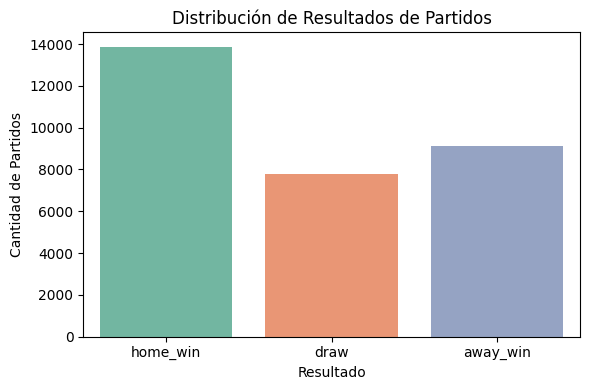

,count
resultado,
home_win,13869
away_win,9110
draw,7776


In [60]:
# Visualización y análisis exploratorio sobre el DataFrame df_model_clean en Colab

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir el DataFrame de Spark a Pandas
df_pd = df_total.toPandas()

# Ver las primeras filas
df_head = df_pd.head()

# Describir estadísticas básicas
df_description = df_pd.describe(include='all')

# Recuento de resultados
resultado_counts = df_pd["resultado"].value_counts()

# Gráfico de distribución de resultados
plt.figure(figsize=(6, 4))
sns.countplot(data=df_pd, x="resultado", order=["home_win", "draw", "away_win"], palette="Set2")
plt.title("Distribución de Resultados de Partidos")
plt.xlabel("Resultado")
plt.ylabel("Cantidad de Partidos")
plt.tight_layout()
plt.show()

resultado_counts


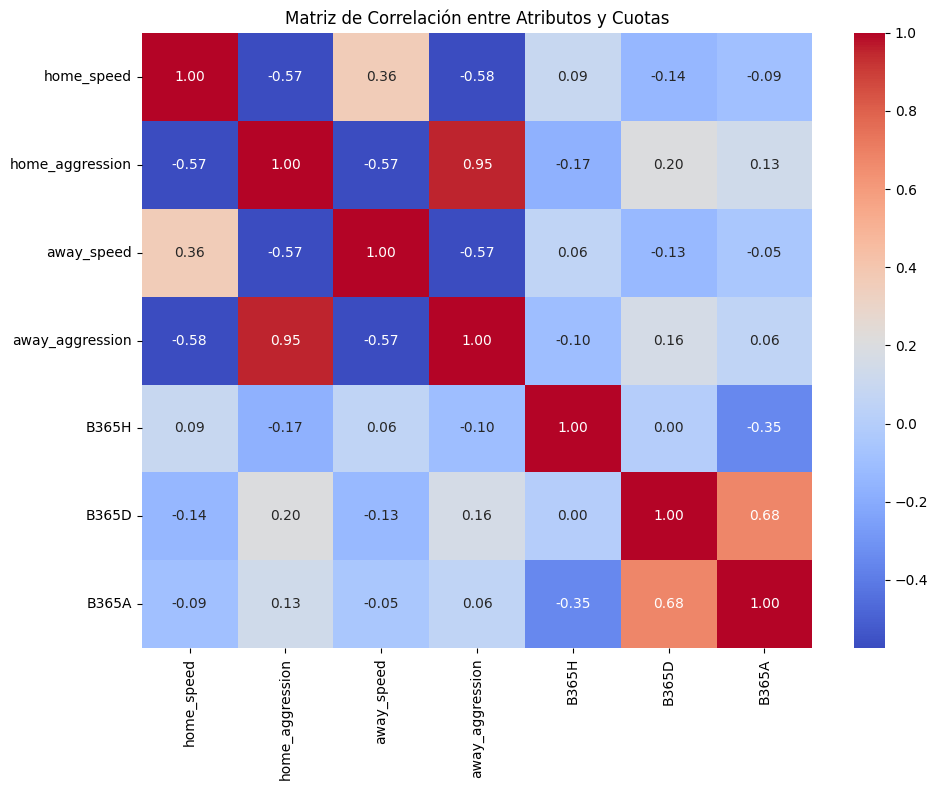

In [61]:
# Correlación entre cuotas y atributos
plt.figure(figsize=(10, 8))
sns.heatmap(df_pd[[
    "home_speed", "home_aggression", "away_speed", "away_aggression",
    "B365H", "B365D", "B365A"
]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Atributos y Cuotas")
plt.tight_layout()
plt.show()

<ipython-input-62-4716a41847dd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pd, x="resultado", y="home_aggression", palette="Pastel1")


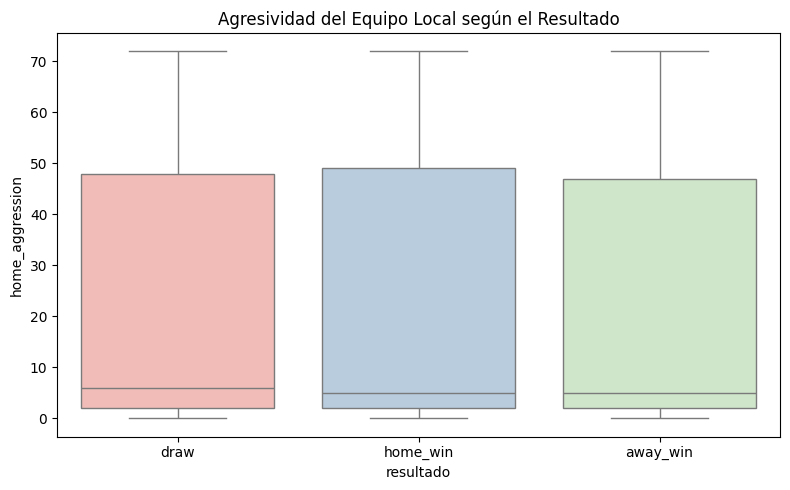

In [62]:
# Boxplot: agresividad vs resultado
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_pd, x="resultado", y="home_aggression", palette="Pastel1")
plt.title("Agresividad del Equipo Local según el Resultado")
plt.tight_layout()
plt.show()

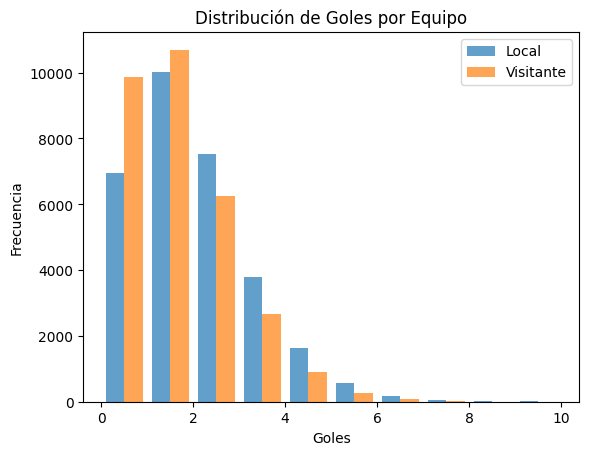

In [104]:
import matplotlib.pyplot as plt

goles_home = df_total.select("home_team_goal").toPandas()
goles_away = df_total.select("away_team_goal").toPandas()

plt.hist([goles_home["home_team_goal"], goles_away["away_team_goal"]], bins=range(0, 11), label=["Local", "Visitante"], alpha=0.7)
plt.xlabel("Goles")
plt.ylabel("Frecuencia")
plt.title("Distribución de Goles por Equipo")
plt.legend()
plt.show()
